## CASE STUDY - Deploying a recommender

We have seen the movie lens data on a toy dataset now lets try something a little bigger.  You have some
choices.

* [MovieLens Downloads](https://grouplens.org/datasets/movielens/latest/)

If your resources are limited (your working on a computer with limited amount of memory)

> continue to use the sample_movielens_ranting.csv

If you have a computer with at least 8GB of RAM

> download the ml-latest-small.zip

If you have the computational resources (access to Spark cluster or high-memory machine)

> download the ml-latest.zip

The two important pages for documentation are below.

* [Spark MLlib collaborative filtering docs](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html) 
* [Spark ALS docs](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.recommendation.ALS)


In [83]:
import os
import shutil
import pandas as pd
import numpy as np
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.sql import Row, SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *

In [2]:
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[8]'))
spark = SparkSession.builder.getOrCreate()

print(spark.version) 

3.0.0


### ensure the data are downloaded and specify the file paths here


In [3]:
dr = os.path.abspath('../data/ml-latest-small')

paths = {
    'g_scores': './genome-scores.csv',
    'g_tags': './genome-tags.csv',
    'links': './links.csv',
    'movies': './movies.csv',
    'tags': './tags.csv',
    'ratings': './ratings.csv',
}

In [16]:
ratings_schema = StructType([
    StructField('userId', FloatType(), True), 
    StructField('movieId', FloatType(), True), 
    StructField('rating', FloatType(), True), 
    StructField('timestamp', FloatType(), True)
])
movies_schema = StructType([
    StructField('movieId', IntegerType(), True),
    StructField('title', StringType(), True),
    StructField('genres', StringType(), True)
])

In [34]:
# g_scores_df = spark.read.csv(os.path.join(dr, paths['g_scores']))
# g_tags_df = spark.read.csv(os.path.join(dr, paths['g_tags']))
# links_df = spark.read.csv(os.path.join(dr, paths['links']))
movies_df = spark.read.csv(os.path.join(dr, paths['movies']), inferSchema = 'true', header = True)
ratings_df = spark.read.csv(os.path.join(dr, paths['ratings']), inferSchema = 'true', header = True)
# tags_df = spark.read.csv(os.path.join(dr, paths['tags']))

In [35]:
movies_df.createOrReplaceTempView('movies')
ratings_df.createOrReplaceTempView('ratings')

## QUESTION 1

Explore the movie lens data a little and summarize it

In [36]:
movies_df.show(truncate = False)

+-------+-------------------------------------+-------------------------------------------+
|movieId|title                                |genres                                     |
+-------+-------------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                       |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)              |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)   |Comedy                                     |
|6      |Heat (1995)                          |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                       |Comedy|Romance                             |
|8      |Tom and Huck (1995)                  |Adventure|Children               

In [37]:
movies_df.groupBy('genres').count().sort('count', ascending = False).show(truncate = False)

+-----------------------+-----+
|genres                 |count|
+-----------------------+-----+
|Drama                  |1053 |
|Comedy                 |946  |
|Comedy|Drama           |435  |
|Comedy|Romance         |363  |
|Drama|Romance          |349  |
|Documentary            |339  |
|Comedy|Drama|Romance   |276  |
|Drama|Thriller         |168  |
|Horror                 |167  |
|Horror|Thriller        |135  |
|Crime|Drama            |134  |
|Crime|Drama|Thriller   |125  |
|Drama|War              |114  |
|Comedy|Crime           |101  |
|Action|Comedy          |92   |
|Thriller               |84   |
|Children|Comedy        |74   |
|Comedy|Horror          |69   |
|Action|Crime|Thriller  |66   |
|Action|Adventure|Sci-Fi|66   |
+-----------------------+-----+
only showing top 20 rows



In [38]:
duplicates = movies_df.dropDuplicates()
duplicates.summary().show()

+-------+------------------+--------------------+------------------+
|summary|           movieId|               title|            genres|
+-------+------------------+--------------------+------------------+
|  count|              9742|                9742|              9742|
|   mean|42200.353623485935|                null|              null|
| stddev| 52160.49485443833|                null|              null|
|    min|                 1|"11'09""01 - Sept...|(no genres listed)|
|    25%|            193609|                null|              null|
|    50%|            193609|                null|              null|
|    75%|             76251|                null|              null|
|    max|            193609|À nous la liberté...|           Western|
+-------+------------------+--------------------+------------------+



In [39]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



## QUESTION 2

Find the ten most popular movies---that is the then movies with the highest average rating

>Hint: you may want to subset the movie matrix to only consider movies with a minimum number of ratings

In [40]:
spark.sql('''
    SELECT 
        MIN(num_ratings), MAX(num_ratings), MEAN(num_ratings),
        MIN(mean_rating), MAX(mean_rating), MEAN(mean_rating)
        FROM (
        SELECT 
            COUNT(rating) AS num_ratings, MEAN(rating) AS mean_rating
            FROM ratings GROUP BY movieId
        )
''').show()

+----------------+----------------+------------------+----------------+----------------+-----------------+
|min(num_ratings)|max(num_ratings)| mean(num_ratings)|min(mean_rating)|max(mean_rating)|mean(mean_rating)|
+----------------+----------------+------------------+----------------+----------------+-----------------+
|               1|             329|10.369806663924312|             0.5|             5.0|3.262448274810963|
+----------------+----------------+------------------+----------------+----------------+-----------------+



In [41]:
spark.sql('''
    SELECT * FROM (
        SELECT 
            MEAN(rating) AS mean_rating, COUNT(rating) as num_ratings, movieId
            FROM ratings
            GROUP BY movieId
            ORDER BY num_ratings, mean_rating DESC
    ) WHERE num_ratings > 75
    ORDER BY mean_rating DESC
''').show()

+------------------+-----------+-------+
|       mean_rating|num_ratings|movieId|
+------------------+-----------+-------+
| 4.429022082018927|        317|    318|
|         4.2890625|        192|    858|
| 4.272935779816514|        218|   2959|
| 4.268041237113402|         97|    750|
| 4.261904761904762|         84|    904|
|  4.25968992248062|        129|   1221|
| 4.252336448598131|        107|  48516|
|              4.25|        126|   1213|
|              4.24|        100|    912|
| 4.238255033557047|        149|  58559|
| 4.237745098039215|        204|     50|
| 4.232394366197183|        142|   1197|
| 4.231075697211155|        251|    260|
|             4.225|        220|    527|
| 4.219626168224299|        107|   1208|
| 4.217054263565892|        129|   2329|
|4.2156398104265405|        211|   1196|
|            4.2075|        200|   1198|
| 4.203007518796992|        133|   1193|
| 4.202290076335878|        131|   1089|
+------------------+-----------+-------+
only showing top

In [42]:
spark.sql('''
    SELECT 
        title, mean_rating, num_ratings, movieId
        FROM movies
        INNER JOIN (
            SELECT 
                MEAN(rating) AS mean_rating, COUNT(rating) as num_ratings, movieId as ratings_id
                FROM ratings
                GROUP BY movieId
                ORDER BY num_ratings, mean_rating DESC
            
        ) ratings_table
        ON movies.movieId = ratings_table.ratings_id
        WHERE num_ratings > 75
        ORDER BY mean_rating DESC
        LIMIT 10
''').show(truncate = False)

+---------------------------------------------------------------------------+-----------------+-----------+-------+
|title                                                                      |mean_rating      |num_ratings|movieId|
+---------------------------------------------------------------------------+-----------------+-----------+-------+
|Shawshank Redemption, The (1994)                                           |4.429022082018927|317        |318    |
|Godfather, The (1972)                                                      |4.2890625        |192        |858    |
|Fight Club (1999)                                                          |4.272935779816514|218        |2959   |
|Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)|4.268041237113402|97         |750    |
|Rear Window (1954)                                                         |4.261904761904762|84         |904    |
|Godfather: Part II, The (1974)                                         

In [43]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



## QUESTION 3

Compare at least 5 different values for the ``regParam``

Use the `` ALS.trainImplicit()`` and compare it to the ``.fit()`` method.  See the [Spark ALS docs](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.recommendation.ALS)
for example usage. 

In [49]:
def als_train_model(train, test, latent_factors, rp, ip = False):
    als = ALS(
        maxIter = 5,
        rank = latent_factors,
        regParam = rp,
        userCol = 'userId', 
        itemCol = 'movieId', 
        ratingCol = 'rating',
        implicitPrefs = ip,
        coldStartStrategy = 'drop'
    )
    model = als.fit(train)
    pred = model.transform(test)
    evaluator = RegressionEvaluator(
        metricName = 'rmse',
        predictionCol = 'prediction',
        labelCol = 'rating'
    )
    rmse = evaluator.evaluate(pred)
    return rmse

In [50]:
train, test = ratings_df.randomSplit([0.9, 0.1])

model_pred = list()

for latent_factors in range(5, 31, 5):
    print('latent factors', latent_factors)
    for regParam in [0.5, 0.1, 0.05, 0.01, 0.005]:
        
        model_pred.append(
            (als_train_model(train, test, latent_factors, regParam), 
            latent_factors, 
            regParam)
        )

for rmse, latent_factors, regParam in model_pred:
    print(f'With latent factors = {latent_factors}, regParam = {regParam}, RMSE = {rmse}')

latent factors 5
latent factors 10
latent factors 15
latent factors 20
latent factors 25
latent factors 30
With latent factors = 5, regParam = 0.5, RMSE = 0.9948204746276237
With latent factors = 5, regParam = 0.1, RMSE = 0.873709724574041
With latent factors = 5, regParam = 0.05, RMSE = 0.9031745249378167
With latent factors = 5, regParam = 0.01, RMSE = 0.9727481164431061
With latent factors = 5, regParam = 0.005, RMSE = 1.0015755767953094
With latent factors = 10, regParam = 0.5, RMSE = 1.0007618632884374
With latent factors = 10, regParam = 0.1, RMSE = 0.8719155285425322
With latent factors = 10, regParam = 0.05, RMSE = 0.9192205952748745
With latent factors = 10, regParam = 0.01, RMSE = 1.0424789187392565
With latent factors = 10, regParam = 0.005, RMSE = 1.0881646316741342
With latent factors = 15, regParam = 0.5, RMSE = 1.0027117885844872
With latent factors = 15, regParam = 0.1, RMSE = 0.8763526617578207
With latent factors = 15, regParam = 0.05, RMSE = 0.9348311539541733
With l

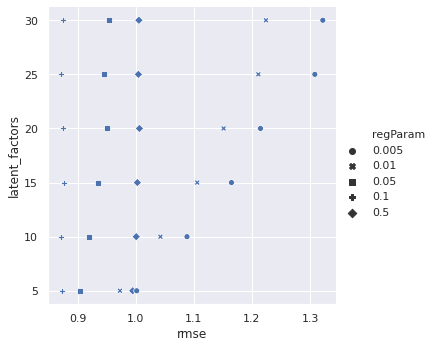

In [54]:
import seaborn as sns
sns.set()

err = pd.DataFrame(model_pred, columns = ['rmse', 'latent_factors', 'regParam'])

sns.relplot(x = 'rmse', y = 'latent_factors', style= 'regParam', data = err)

## QUESTION 4

With your best `regParam` try using the `implicitPrefs` flag.

In [56]:
als_train_model(train, test, 25, 0.1, ip = True)

3.220105556105446

In [61]:
model_pred_ip = list()

for latent_factors in range(5, 31, 5):
    print('latent factors', latent_factors)
    for regParam in [0.5, 0.1, 0.05, 0.01, 0.005]:
        
        model_pred_ip.append(
            (als_train_model(train, test, latent_factors, regParam, ip = True), 
            latent_factors, 
            regParam)
        )

for rmse, latent_factors, regParam in model_pred_ip:
    print(f'With latent factors = {latent_factors}, regParam = {regParam}, RMSE = {rmse}')

latent factors 5
latent factors 10
latent factors 15
latent factors 20
latent factors 25
latent factors 30
With latent factors = 5, regParam = 0.5, RMSE = 3.2710848674433413
With latent factors = 5, regParam = 0.1, RMSE = 3.222700843613907
With latent factors = 5, regParam = 0.05, RMSE = 3.2186106098624574
With latent factors = 5, regParam = 0.01, RMSE = 3.209108171979812
With latent factors = 5, regParam = 0.005, RMSE = 3.205484288006874
With latent factors = 10, regParam = 0.5, RMSE = 3.2611092235299663
With latent factors = 10, regParam = 0.1, RMSE = 3.206638372223324
With latent factors = 10, regParam = 0.05, RMSE = 3.200680722562006
With latent factors = 10, regParam = 0.01, RMSE = 3.190030134383357
With latent factors = 10, regParam = 0.005, RMSE = 3.187414198744593
With latent factors = 15, regParam = 0.5, RMSE = 3.257720722439735
With latent factors = 15, regParam = 0.1, RMSE = 3.207275599100202
With latent factors = 15, regParam = 0.05, RMSE = 3.202439211291463
With latent fac

In [67]:
min([e[0] for e in model_pred_ip])

3.187414198744593

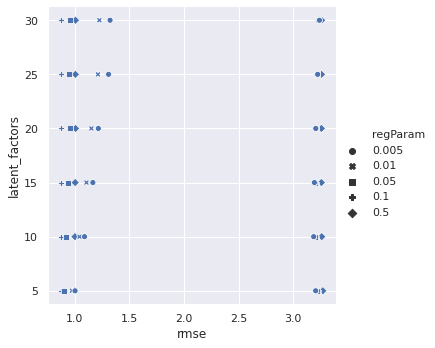

In [62]:
err_ip = pd.DataFrame(model_pred, columns = ['rmse', 'latent_factors', 'regParam'])

sns.relplot(x = 'rmse', y = 'latent_factors', style= 'regParam', data = err_ip)

### 10 latent factors and a regParam 0f 0.005 achieve the best RMSE with the implicitPerfs tag.

## QUESTION 5

Use model persistence to save your finalized model

In [77]:
model_path = '../models'
ip_path = 'ip_als_model'
als_path = 'als_model'

In [74]:
ip_als = ALS(maxIter = 5,
        rank = 10,
        regParam = 0.005,
        userCol = 'userId', 
        itemCol = 'movieId', 
        ratingCol = 'rating',
        implicitPrefs = True,
        coldStartStrategy = 'drop')
als = ALS(maxIter = 5,
        rank = 25,
        regParam = 0.1,
        userCol = 'userId', 
        itemCol = 'movieId', 
        ratingCol = 'rating',
        implicitPrefs = False,
        coldStartStrategy = 'drop')

ip_model = ip_als.fit(train)
als_model = als.fit(train)

ip_model.save(os.path.join(model_path, ip_path)
als_model.save(os.path.join(model_path, als_path))

In [75]:
!ls -a ../models

.  ..  als_model  ip_als_model


## QUESTION 6

Use ``spark-submit`` to load the model and demonstrate that you can load the model and interface with it.

In [84]:
ip_als_model = ALSModel.load(os.path.join(model_path, ip_path))
als_model = ALSModel.load(os.path.join(model_path, als_path))

In [87]:
ip_pred = ip_model.transform(test)

ip_evaluator = RegressionEvaluator(
    metricName = 'rmse',
    predictionCol = 'prediction',
    labelCol = 'rating'
)

evaluator.evaluate(ip_pred)

3.187414198744593

In [88]:
als_pred = als_model.transform(test)

evaluator = RegressionEvaluator(
    metricName = 'rmse',
    predictionCol = 'prediction',
    labelCol = 'rating'
)

evaluator.evaluate(als_pred)

0.8708918741477119